In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:

data = pd.read_csv("../data/processed/apple.csv", index_col="Date")
if data.isna().any().any():
    print("Data contains NaN values. Please handle them before proceeding.")
    print(data[data.isna().any(axis=1)])
if (data == float('inf')).any().any() or (data == float('-inf')).any().any():
    data = data.replace([float('inf'), float('-inf')], None)
    data = data.dropna()
    
# data = data[:4000]


# print(data.shape)

x = data.iloc[:, :data.shape[1] - 1].values
y = data.iloc[:, data.shape[1] - 1].values

split = int(data.shape[0] * 0.95)
split2 = 70

train_x, test_x = x[: split, :], x[split + split2:, :]
train_y, test_y = y[: split, ], y[split + split2:, ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (7553, 39) trainY: (7553,)
testX: (328, 39) testY: (328,)


In [3]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [4]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([39, 400, 400, 400, 10], 10)

[1/150] Loss: 2099.001366853714
[2/150] Loss: 2015.5264016389847
[3/150] Loss: 1931.7164378166199
[4/150] Loss: 1876.0555229187012
[5/150] Loss: 1805.0834625959396
[6/150] Loss: 1737.8354361057281
[7/150] Loss: 1666.1866734027863
[8/150] Loss: 1593.4713866710663
[9/150] Loss: 1538.1972502470016
[10/150] Loss: 1474.490494608879
[11/150] Loss: 1389.0372002124786
[12/150] Loss: 1352.1909284591675
[13/150] Loss: 1277.661114692688
[14/150] Loss: 1226.521332025528
[15/150] Loss: 1174.0353956222534
[16/150] Loss: 1108.514529466629
[17/150] Loss: 1069.4665710926056
[18/150] Loss: 1009.0057426691055
[19/150] Loss: 954.2205247879028
[20/150] Loss: 923.8089596033096
[21/150] Loss: 880.1191146373749
[22/150] Loss: 823.610155582428
[23/150] Loss: 782.9821692705154
[24/150] Loss: 762.5225586891174
[25/150] Loss: 716.111711025238
[26/150] Loss: 669.362370967865
[27/150] Loss: 644.5265017747879
[28/150] Loss: 620.7610157728195
[29/150] Loss: 586.023206114769
[30/150] Loss: 546.5885951519012
[31/150] L

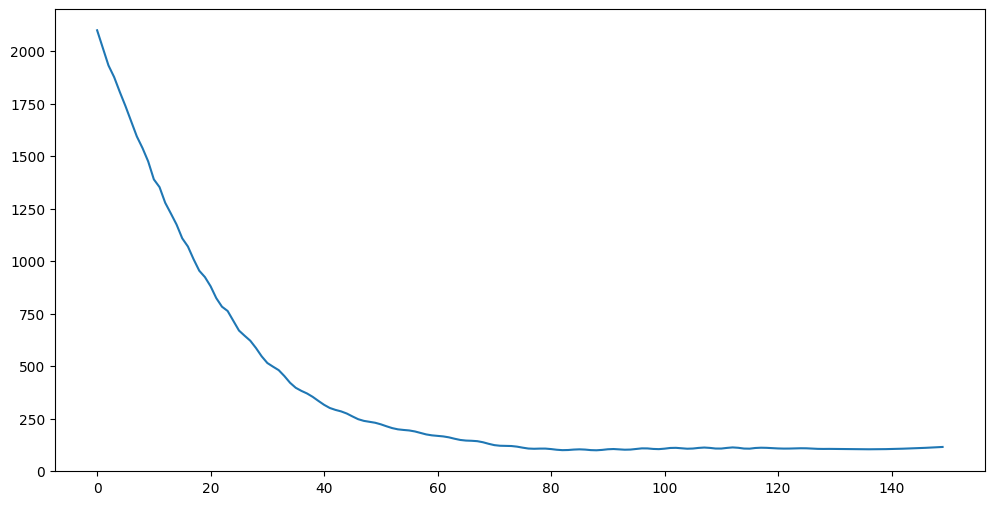

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 150
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [6]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [7]:

def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float() 
    return x_, y_
     

In [8]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [9]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')

train_x: torch.Size([7550, 3, 49]) train_y: torch.Size([7550, 1])
test_x: torch.Size([325, 3, 49]) test_y: torch.Size([325, 1])


In [10]:
class StockTransformer(nn.Module):
    def __init__(self, feature_dim, seq_len, target_dim, d_model=256, num_heads=4, num_layers=3, ff_dim=256, dropout=0.3):
        super(StockTransformer, self).__init__()
        
        self.input_embedding = nn.Linear(feature_dim, d_model)
        
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, target_dim)
        )

    def forward(self, x):
        x = self.input_embedding(x) 
        x = x + self.positional_encoding[:, :x.size(1), :] 
        
        
        x = x.permute(1, 0, 2) 
        
        
        encoded = self.transformer_encoder(x) 
        
        output = encoded[-1, :, :] 
        
        output = self.fc(output) 
        return output

In [11]:
import torch.optim as optim

model = StockTransformer(feature_dim=49, seq_len=3, target_dim=1)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

/Users/huynhnguyen/Stock-Prediction-Deep-Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
num_epochs = 30
batch_size = 256


train_dataset = torch.utils.data.TensorDataset(train_x_slide, train_y_slide)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    hist[epoch] = epoch_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader)}")

    model.eval()
    with torch.no_grad():
        test_predictions = model(test_x_slide)
        test_loss = criterion(test_predictions, test_y_slide)
        print(f"Test Loss: {test_loss.item()}")

Epoch [1/30], Loss: 0.0026487374134982625
Test Loss: 0.011244060471653938
Epoch [2/30], Loss: 0.002736026793718338
Test Loss: 0.011196267791092396
Epoch [3/30], Loss: 0.00280895580460007
Test Loss: 0.005898732226341963
Epoch [4/30], Loss: 0.002602477751982709
Test Loss: 0.011513490229845047
Epoch [5/30], Loss: 0.002564550843089819
Test Loss: 0.01311375293880701
Epoch [6/30], Loss: 0.0027230966836214064
Test Loss: 0.008011799305677414
Epoch [7/30], Loss: 0.0024685553546684486
Test Loss: 0.011661708354949951
Epoch [8/30], Loss: 0.0026348013430833816
Test Loss: 0.007302470505237579
Epoch [9/30], Loss: 0.002348631954131027
Test Loss: 0.008495453745126724
Epoch [10/30], Loss: 0.002232992936236163
Test Loss: 0.005404624622315168
Epoch [11/30], Loss: 0.0025784123650131126
Test Loss: 0.061077095568180084
Epoch [12/30], Loss: 0.0022460278783303996
Test Loss: 0.007796909660100937
Epoch [13/30], Loss: 0.0024331244368416566
Test Loss: 0.008327865973114967
Epoch [14/30], Loss: 0.0021751402295194567

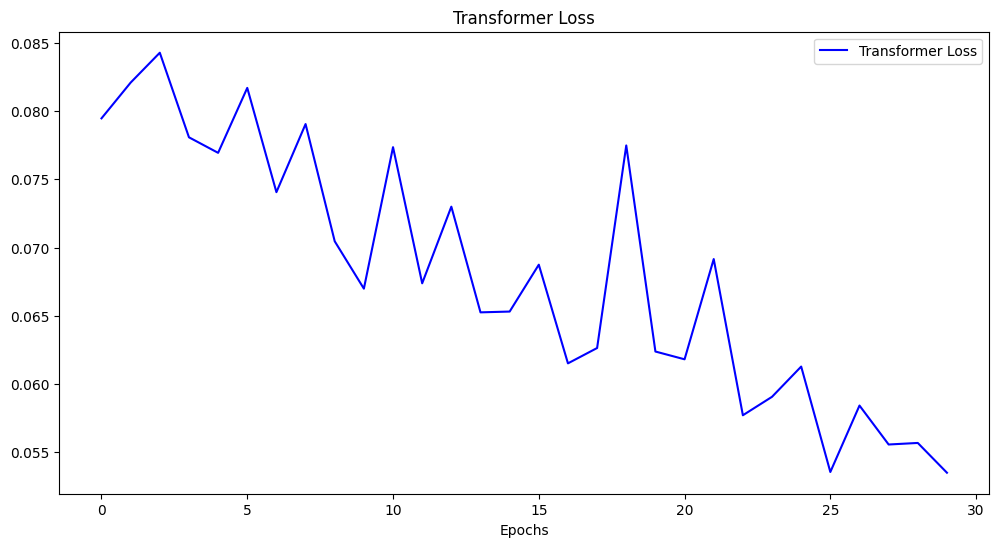

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(hist, color = 'blue', label = 'Transformer Loss')
plt.title('Transformer Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [16]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:4.793371585166993


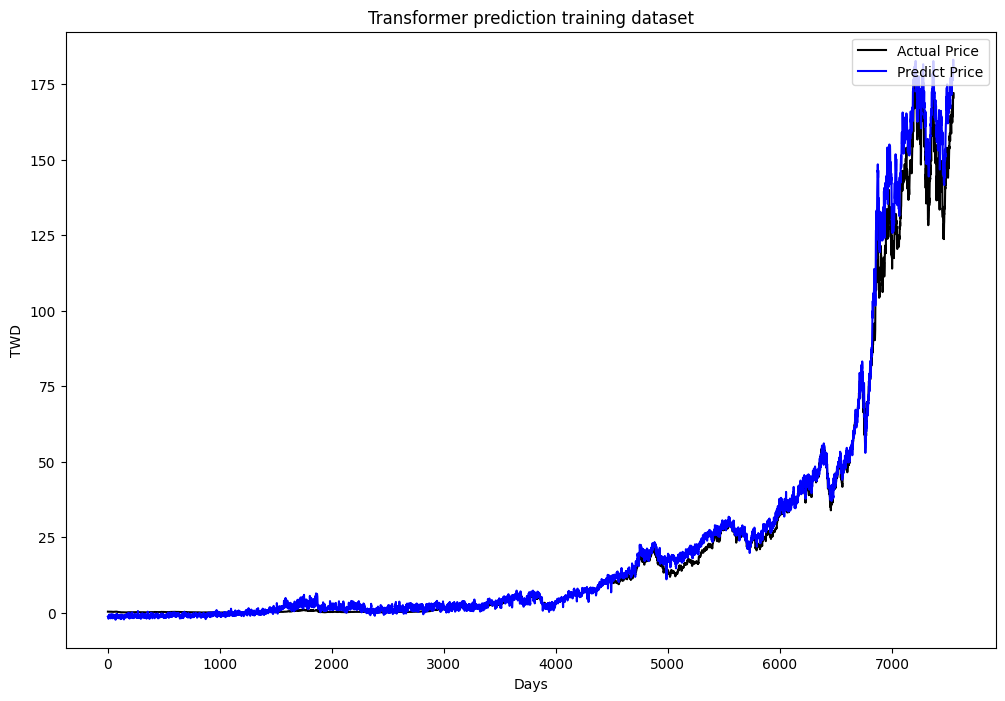

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('Transformer prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:14.037445018075521


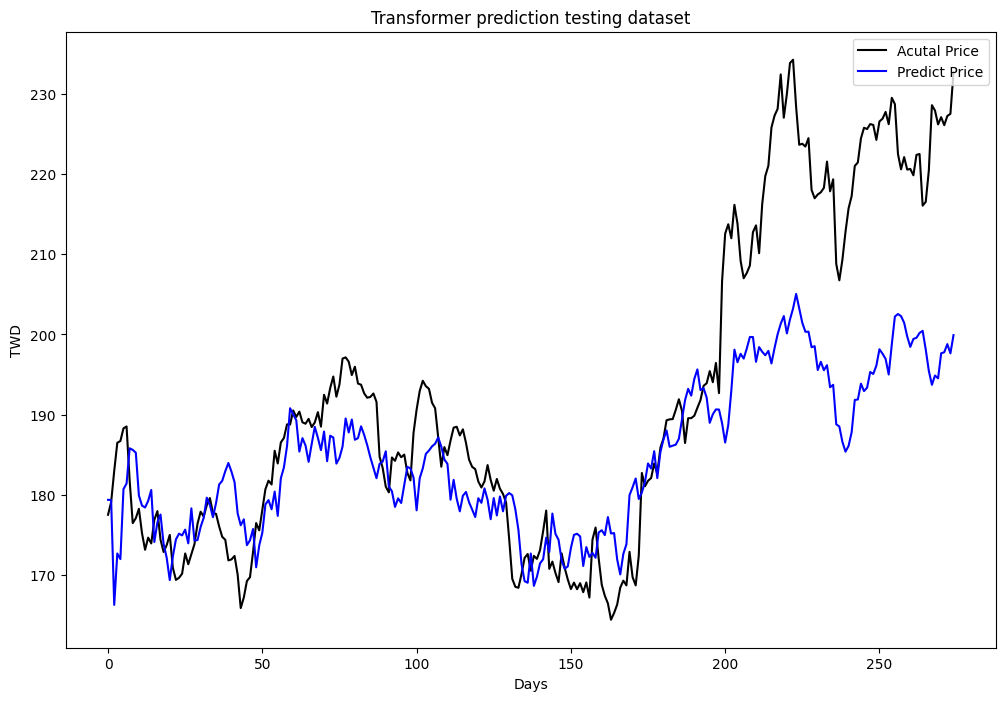

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true[:-50], color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred[:-50], color = 'blue', label = 'Predict Price')
plt.title('Transformer prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true[:-50], y_test_pred[:-50])
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [27]:
torch.save(model.state_dict(), './models/transformer_model.pt')

# Without VAE

In [22]:
data = pd.read_csv("../data/processed/apple.csv", index_col="Date")
if data.isna().any().any():
    print("Data contains NaN values. Please handle them before proceeding.")
    print(data[data.isna().any(axis=1)])
if (data == float('inf')).any().any() or (data == float('-inf')).any().any():
    data = data.replace([float('inf'), float('-inf')], None)
    data = data.dropna()
    
# data = data[:4000]


# print(data.shape)

x = data.iloc[:, :data.shape[1] - 1].values
y = data.iloc[:, data.shape[1] - 1].values

split = int(data.shape[0] * 0.95)
split2 = 70

train_x, test_x = x[: split, :], x[split + split2:, :]
train_y, test_y = y[: split, ], y[split + split2:, ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (7553, 39) trainY: (7553,)
testX: (328, 39) testY: (328,)


In [23]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')

train_x: torch.Size([7550, 3, 39]) train_y: torch.Size([7550, 1])
test_x: torch.Size([325, 3, 39]) test_y: torch.Size([325, 1])


In [24]:
import torch.optim as optim

model = StockTransformer(feature_dim=39, seq_len=3, target_dim=1)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

/Users/huynhnguyen/Stock-Prediction-Deep-Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [25]:
num_epochs = 30
batch_size = 256


train_dataset = torch.utils.data.TensorDataset(train_x_slide, train_y_slide)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    hist[epoch] = epoch_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader)}")

    model.eval()
    with torch.no_grad():
        test_predictions = model(test_x_slide)
        test_loss = criterion(test_predictions, test_y_slide)
        print(f"Test Loss: {test_loss.item()}")

Epoch [1/30], Loss: 0.0323591817325602
Test Loss: 0.10512065887451172
Epoch [2/30], Loss: 0.004628784651868045
Test Loss: 0.09536506980657578
Epoch [3/30], Loss: 0.0038703231684242686
Test Loss: 0.06768190860748291
Epoch [4/30], Loss: 0.003843209434611102
Test Loss: 0.07346142828464508
Epoch [5/30], Loss: 0.0035709703573957086
Test Loss: 0.07934299856424332
Epoch [6/30], Loss: 0.0031942448190723856
Test Loss: 0.07201991975307465
Epoch [7/30], Loss: 0.0031318402344671387
Test Loss: 0.06767307221889496
Epoch [8/30], Loss: 0.0029263685379798212
Test Loss: 0.06489747762680054
Epoch [9/30], Loss: 0.0026539870693037906
Test Loss: 0.08064708113670349
Epoch [10/30], Loss: 0.002802735019940883
Test Loss: 0.07719606906175613
Epoch [11/30], Loss: 0.0028592882639107606
Test Loss: 0.06010802090167999
Epoch [12/30], Loss: 0.0031427226223361988
Test Loss: 0.06642675399780273
Epoch [13/30], Loss: 0.0025763136295912166
Test Loss: 0.07682660967111588
Epoch [14/30], Loss: 0.0027666290445874137
Test Loss:

In [26]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:7.062723340799265


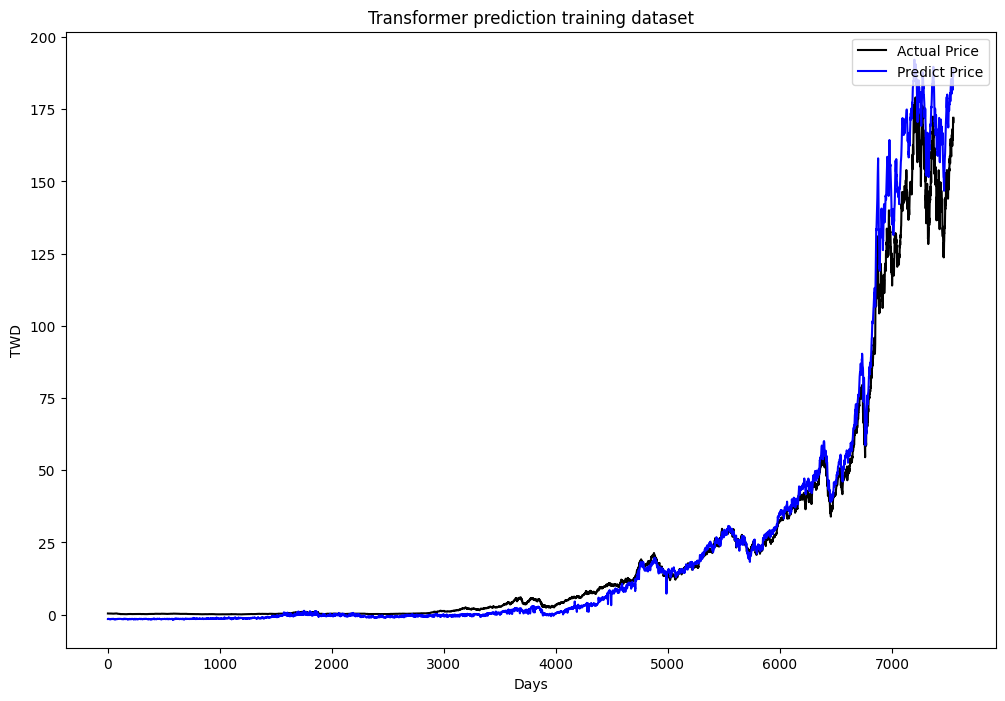

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('Transformer prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:17.29835822330498


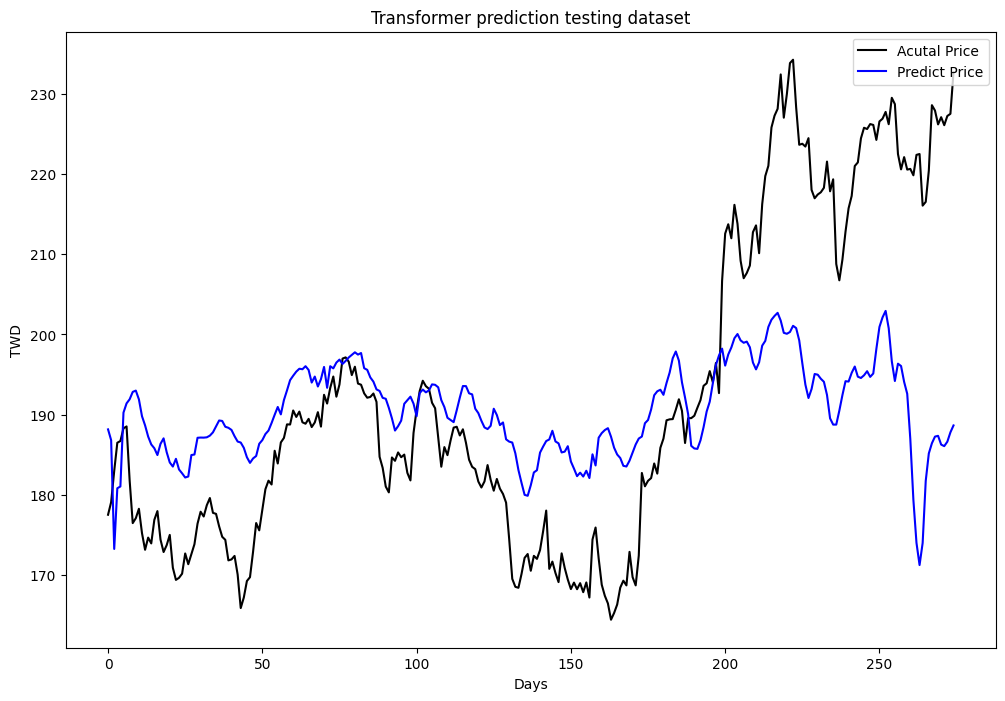

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true[:-50], color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred[:-50], color = 'blue', label = 'Predict Price')
plt.title('Transformer prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true[:-50], y_test_pred[:-50])
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')